In [24]:
#Importar librerias
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import modulo_conn_sql as mcq
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model

from pickle import dump
from pickle import load

from io import BytesIO

import sqlalchemy as sa
import urllib

import warnings
warnings.filterwarnings('ignore')

def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)


In [26]:
############################################# PARAMETROS #############################################
# EL ENTRENAMIENTO DE LAS PLANTAS DE COLOMBIA PUEDE DURAR HASTA 12HRS!!! EJECUTESE CON PRECAUCION 
############################################# PARAMETROS #############################################


#PRINCIPAL

############################################# PARAMETROS #############################################
pais = 'Colombia'
inicioHistoria = datetime.datetime(2014, 1, 1) #'2013-05-01'
finHistoria = datetime.datetime.today()


######################################### CONSULTA BD #############################################

#Consulta de datos en la base SQL
despachosSQL = querySQL(  "{CALL SCAC_AP8_BaseForecast (?,?,?)}", (pais, inicioHistoria.strftime("%Y-%m-%d"), finHistoria.strftime("%Y-%m-%d") ) )

nombre_cluster = querySQL( "SELECT Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais) )

################################### PRE-PROCESAMIENTO DE LOS DATOS #############################################

df = pd.merge(despachosSQL, nombre_cluster, left_on='Planta', right_on='Centro')
df1 = df.groupby(['PlantaUnica','FechaEntrega']).agg({'totalEntregado': 'sum'}).reset_index()

df1['DiaSemana'] = df1['FechaEntrega'].dt.dayofweek
df1['año'] = df1['FechaEntrega'].dt.year

################################### Estructura RNR #############################################

#Memoria corto plazo
timesteps = 15
#numero de neuronas
un = 120
#coeficiente de olvido
do = 0.05
#numero de ciclos
ep = 1100

plantas = df1.PlantaUnica.unique()

log_exceptions = [] # array para almacenar errores al tratar de entrenar la red neuronal

for planta_target in plantas:
    
    df_target = df1[df1['PlantaUnica']==planta_target]

    dataset_array = df_target.iloc[: , 2:5].values

    #Defino el dataset de entrenamiento
    dataset_train = df_target[ df_target['FechaEntrega'] < finHistoria]
    training_set  = dataset_train.iloc[: , 2:5].values

    # Escalado de características
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_array_scaled = sc.fit_transform(dataset_array)
    training_set_scaled = sc.transform(training_set)
    
    #en encapsula en un try/catch ya que las plantas nuevas pueden fallar por falta de datos (entre otros cosas)
    try:
        
        # Guardar el escalador
        dump(sc, open("../datos/"+ planta_target + ".pkl", "wb"))

        #defino un array por cada variable predictora
        X_train = []
        X_train_material = []
        X_train_DiaSemana = []
        X_train_Year = []

        y_train = []

        for i in range(timesteps, len(training_set)):
            #columna 0 -> Cantidad Material
            X_train_material.append( training_set_scaled[i-timesteps:i, 0])

            #columna 1 -> DiaSemana
            X_train_DiaSemana.append( training_set_scaled[i-timesteps:i, 1])

            #columna 2 -> Year
            X_train_Year.append( training_set_scaled[i-timesteps:i, 2])


            y_train.append(training_set_scaled[i, 0])

        #se convierten los array en objetos numpy    
        X_train_material = np.array( X_train_material)
        X_train_DiaSemana =  np.array(X_train_DiaSemana )
        X_train_Year = np.array( X_train_Year)
        y_train = np.array(y_train)

        #Se agrega una nueva dimension a las variables
        X_train_material = np.reshape(X_train_material, (X_train_material.shape[0], X_train_material.shape[1], 1 ))
        X_train_DiaSemana = np.reshape(X_train_DiaSemana, (X_train_DiaSemana.shape[0], X_train_DiaSemana.shape[1], 1 ))
        X_train_Year = np.reshape(X_train_Year, (X_train_Year.shape[0], X_train_Year.shape[1], 1 ))

        #se crea el la estructura de datos que se le va a pasar al regresor
        X_train = np.append(X_train_material, (X_train_DiaSemana), axis = 2 )
        X_train = np.append(X_train, (X_train_Year), axis = 2 )

        #inicializacion del regresor
        regressor = Sequential()

        #añadir la primera capa de LSTM y la regularización por Dropout
        regressor.add(LSTM(units= un, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
        regressor.add(Dropout(do))

        #añadir nueva capa LSTM
        regressor.add(LSTM(units=un, return_sequences = True))
        regressor.add(Dropout(do))

        #añadir penultima capa
        regressor.add(LSTM(units=un))
        regressor.add(Dropout(do))

        #añadir capa de salida
        regressor.add(Dense(units=1))

        #compilar la RNR
        regressor.compile(optimizer = 'adam', loss='mean_squared_error')

        #ajustar la RNR al conjunto de entrenamiento
        regressor.fit(X_train, y_train, epochs=ep, batch_size = 512, verbose = False)

        #guardar regresor
        regressor.save("../datos/"+ planta_target + ".h5")
        
    except  Exception as e:
        
        log_exceptions.append({'planta': planta_target, 'error': e})
        
if len(log_exceptions) > 0:
    df_log_exceptions = pd.DataFrame(log_exceptions) 
    df_log_exceptions.to_excel("../datos/log_errors.xlsx")

In [63]:
#EJECUCION DE LAS REGRESIONES CON CADA MODELO ENTRENADO

############################################# PARAMETROS #############################################
pais = 'Colombia'
inicioForecast = datetime.datetime.today() - datetime.timedelta(1)
finForecast =  datetime.datetime(2022, 12 , 31)

#Memoria corto plazo
timesteps = 15

######################################### CONSULTA BD #############################################

#Consulta de datos en la base SQL

#Voy a necesitar la historia para el primer timestep del forecast, asi que recorro n veces timesteps hacia atras para asegurar traer informacion
despachosSQL = querySQL(  "{CALL SCAC_AP8_BaseForecast (?,?,?)}", (pais, (inicioForecast - datetime.timedelta(timesteps * 3)).strftime("%Y-%m-%d"), inicioForecast.strftime("%Y-%m-%d") ) )

nombre_cluster = querySQL( "SELECT Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais) )
cluster_planta = nombre_cluster.groupby(['Cluster', 'PlantaUnica', 'Ciudad'])['Centro'].last().reset_index()

calendario = querySQL( "select * from SCAC_AT3_DiasHabilesFuente where [Fecha de entrega] between ? and ? and pais = ? and Días_Operativos = 1" , (inicioForecast, finForecast,  pais) )


In [65]:
################################### PRE-PROCESAMIENTO DE LOS DATOS #############################################

df = pd.merge(despachosSQL, nombre_cluster, left_on='Planta', right_on='Centro')
df1 = df.groupby(['PlantaUnica','FechaEntrega']).agg({'totalEntregado': 'sum'}).reset_index()

df1['DiaSemana'] = df1['FechaEntrega'].dt.dayofweek
df1['año'] = df1['FechaEntrega'].dt.year

# tomo unicamente las variables predictoras
dataset_pred = calendario[['Fecha de entrega', 'Dia_Semana', 'Dia_Semana','Año']]

#tomo unicamente el array que me interasa del dataframe 
predict_set = dataset_pred.iloc[:, 1:].values

plantas = df1.PlantaUnica.unique()

#for planta_target in plantas:
planta_target = 'CO-PLANTA 240'

df_target = df1[df1['PlantaUnica']==planta_target]

#try:

# load the scaler
scaler = load(open("../datos/" + planta_target + '.pkl', 'rb'))
predict_set_scaled = scaler.transform(predict_set)

#cargo el regresor previamente entrenado
regressor = load_model('../datos/' + planta_target + '.h5')

#tomo los ultimos datos del historico como punto de partida del forecast
dataset_test = df_target
test_set  = dataset_test.iloc[:, 2:].values

# Escalado de características
test_set_scaled = scaler.transform(test_set)

#los inputs van a ser los ultimos Timesteps dias del training set, para predecir el primer dia 
inputs = test_set_scaled[len(test_set_scaled) - timesteps: ]

for j in range (0, predict_set_scaled.shape[0] ):
    X_test = []
    X_test_material = []
    X_test_DiaSemana = []
    X_test_Year = []


    for i in range(timesteps, inputs.shape[0]+1 ):

        #columna 0 -> Cantidad Material
        X_test_material.append( inputs[i-timesteps:i, 0])

        #columna 1 -> DiaSemana
        X_test_DiaSemana.append( inputs[i-timesteps:i, 1])

        #columna 2 -> Year
        X_test_Year.append( inputs[i-timesteps:i, 2])


    #se convierten los array en objetos numpy    
    X_test_material = np.array( X_test_material)
    X_test_DiaSemana =  np.array(X_test_DiaSemana )
    X_test_Year = np.array( X_test_Year)

    #Se agrega una nueva dimension a las variables
    X_test_material = np.reshape(X_test_material, (X_test_material.shape[0], X_test_material.shape[1], 1 ))
    X_test_DiaSemana = np.reshape(X_test_DiaSemana, (X_test_DiaSemana.shape[0], X_test_DiaSemana.shape[1], 1 ))
    X_test_Year = np.reshape(X_test_Year, (X_test_Year.shape[0], X_test_Year.shape[1], 1 ))

    #se crea el la estructura de datos que se le va a pasar al regresor
    X_test = np.append(X_test_material, (X_test_DiaSemana), axis = 2 )
    X_test = np.append(X_test, (X_test_Year), axis = 2 )

    # por fin, ejecutar prediccion
    prediction = regressor.predict(X_test)

    #a la prediccion le agrego las demas variables predictoras
    prediction = np.append(prediction, (predict_set_scaled[:len(prediction), 1 : ]), axis=1 )

    inputs = test_set_scaled[len(test_set_scaled) - timesteps:]

    inputs = np.append(inputs, (prediction), axis=0 )

prediction = sc.inverse_transform(prediction)

df_result = pd.DataFrame({'Forecast':prediction[:, 0]})
df_result = pd.concat([dataset_pred, df_result], axis=1)
df_result['PlantaUnica'] = planta_target
df_result = pd.merge(cluster_planta, df_result, on='PlantaUnica')
df_result.rename(columns={'Fecha de entrega': 'FechaEntrega'}, inplace = True)
df_result['Version'] = pd.to_datetime("now").strftime("%Y%m%d%H%M%S")
df_result = df_result[['Centro', 'FechaEntrega', 'Forecast', 'Version']]



params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=USCLDBITVMP01;DATABASE=BI_Tableau;UID=usertableau;PWD=usertableau$")
engine = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)
        
df_result.to_sql("SCAC_AT31A_EscenariosForecast", engine, index=False, if_exists="replace", schema="dbo")

output= BytesIO()
writer = pd.ExcelWriter(output, engine='xlsxwriter')
writer = pd.ExcelWriter("../datos/" + planta_target + "forecast" + ".xlsx", engine="xlsxwriter")
df_result.to_excel(writer)
writer.save()

#except:
    #pass

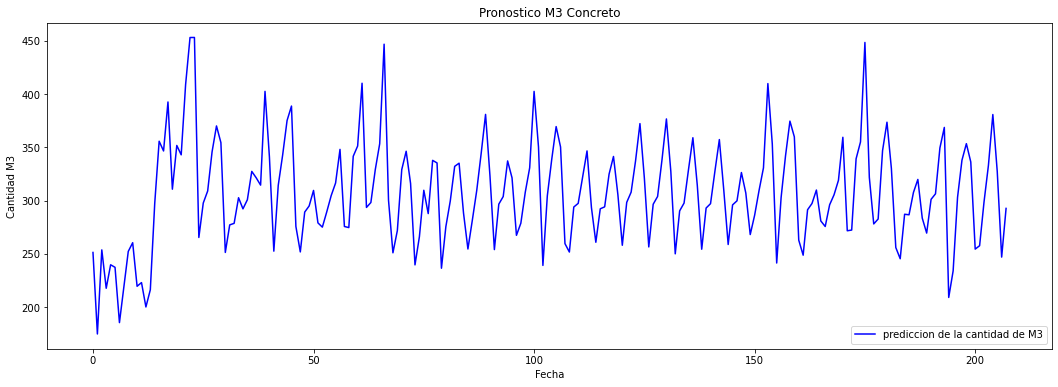

In [55]:
plt.figure(figsize=(18,6))
plt.plot(prediction[:, 0:1], color = 'blue', label = 'prediccion de la cantidad de M3')
plt.title('Pronostico M3 Concreto')
plt.xlabel('Fecha')
plt.ylabel('Cantidad M3')
plt.legend()
plt.show()

In [59]:
df_result = pd.DataFrame({'Forecast':prediction[:, 0]})
df_result = pd.concat([dataset_pred, df_result], axis=1)
df_result['Planta'] = planta_target
#df_result.groupby(['Año','Mes'])['Forecast'].sum()
df_result

,Fecha de entrega,Dia_Semana,Dia_Semana,Año,Forecast,Planta
0,2022-04-22,6,6,2022,251.221059,CO-PLANTA 240
1,2022-04-23,7,7,2022,174.697664,CO-PLANTA 240
2,2022-04-25,2,2,2022,253.648054,CO-PLANTA 240
3,2022-04-26,3,3,2022,217.616163,CO-PLANTA 240
4,2022-04-27,4,4,2022,239.669769,CO-PLANTA 240
...,...,...,...,...,...,...
203,2022-12-27,3,3,2022,333.013455,CO-PLANTA 240
204,2022-12-28,4,4,2022,380.740932,CO-PLANTA 240
205,2022-12-29,5,5,2022,327.242430,CO-PLANTA 240
206,2022-12-30,6,6,2022,246.878752,CO-PLANTA 240
